# Definition
## Inner product
Assume O(0,0), A($x_a$,$y_a$), B($x_b$,$y_b$), then the inner product is defined as:
$$
<OA,OB>=\frac{1}{2}(OA^2+OB^2-AB^2) \\
= \frac{1}{2}(x_a^2 + y_a^2) + \frac{1}{2}(x_b^2 + y_b^2)-\frac{1}{2}[(x_b-x_a)^2+(y_b-y_a)^2]\\
= x_a*x_b + y_a*y_b
$$
Statistics:  
Variance: $\sum_i{(X_i-\bar{X})^2}$ <=> $x_a^2 + y_a^2$  
Covariance: $\sum_i{(X_i-\bar{X})(Y_i-\bar{Y})}$ <=> $x_a*x_b + y_a*y_b$  

## Statistic test
1. Monte Caro test for two series following same distribution: randomly exchange the corresponding values between two series. 
2. Monte Caro test for correlation coefficent: randomly exchange the corresponding values between two distributions.

/Users/zxie0012/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/zxie0012/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


data read finish


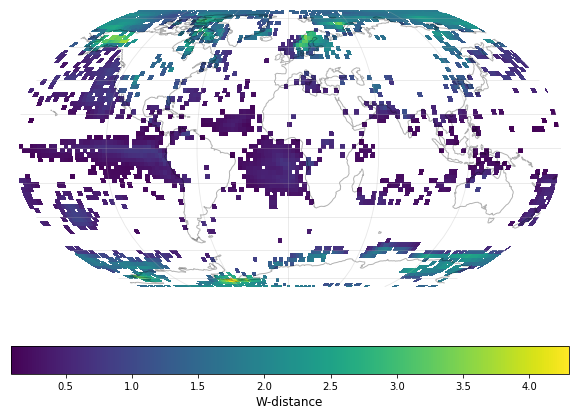

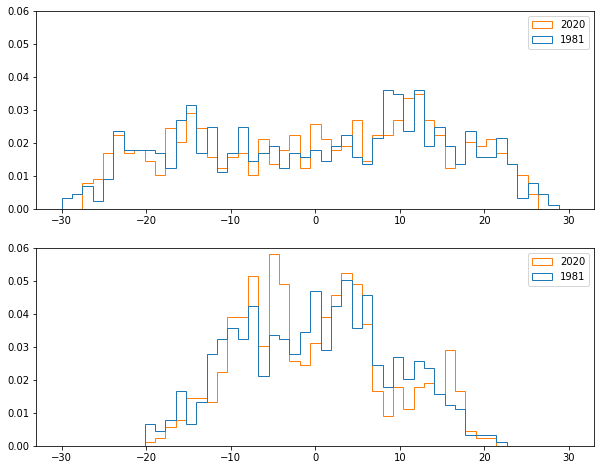

In [1]:
import sys
sys.path.append('/Users/zxie0012/Documents/ice_sheet_model/solo_model_test/global_expriment/script')
import os
from GREB_ISM_LIB import Gvar, ImParam
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def wcorr(f1,f2):
    # correlation coefficient
    from scipy.stats import wasserstein_distance as wdis
    import numpy as np
    f0   = np.random.normal(0,1,1000)
    f1a  = (f1 - np.mean(f1))/np.std(f1)
    f2a  = (f2 - np.mean(f2))/np.std(f2)
    disOA = wdis(f0,f1a)
    disOB = wdis(f0,f2a)
    disAB = wdis(f1a,f2a)
    #if np.max([disOA,disOB])<10*np.min([disOA,disOB]):
    r     = -(disAB**2-disOA**2-disOB**2)/(disOA*disOB*2)
        
    print('W(f0,f1)=%0.3f'%disOA)
    print('W(f0,f2)=%0.3f'%disOB)
    print('W(f1,f2)=%0.3f'%disAB)
    print('Corr. =%0.3f'%r)
    keytab = {'histtype':'step','density':True}
    plt.figure()
    plt.hist([f0,f1a,f2a],**keytab)
    plt.legend(['f2','f1','f0'])
    plt.figure()
    plt.hist(f1a,**keytab)
    plt.figure()
    plt.hist(f2a,**keytab)
    return r 

def wtest(f1,f2,iternum=500):
    # Wasserstein test
    from scipy.stats import wasserstein_distance as wdis
    import numpy as np
    
    #f1a = (f1-np.mean(f1))
    #f2a = (f2-np.mean(f2))
    dim = min([len(f1),len(f2)])
    f1a = np.array(f1 - np.mean(f1))
    f2a = np.array(f2 - np.mean(f2))
    dis = wdis(f1a,f2a)
    
    # Monte Caro test
    dis_exp = np.zeros(iternum)
    for it in range(iternum):
        # exchange random data between two series
        xnum        = np.random.randint(0,dim)
        xind        = np.random.randint(0,dim,xnum)
        f1_t        = f1a.copy()
        f2_t        = f2a.copy() 
        f1_t[xind]  = f2a[xind]
        f2_t[xind]  = f1a[xind]
        # simplely adding random 
        # f1_t        = f1a + np.random.normal(0,1,len(f1a))
        # f2_t        = f2a + np.random.normal(0,1,len(f2a))
        dis_exp[it] = wdis(f1_t,f2_t)
    dis_test = np.sort(dis_exp)
    
    dis_sig  = dis > dis_test[-4]
    return dis,dis_sig
    
def Main():
    def data_calculation_loop():
        for ilon in dim['lon']:
            print(ilon)
            for ilat in dim['lat']:
                temp1 = t81.sel(lon=ilon,lat=ilat).squeeze()
                temp2 = t20.sel(lon=ilon,lat=ilat).squeeze()
                dis,dis_sig = wtest(temp1,temp2)
                wdis.loc[dict(lon=ilon,lat=ilat)] = dis
                wtst.loc[dict(lon=ilon,lat=ilat)] = dis_sig
        dout = xr.merge([wdis,wtst]).drop('time')
        #os.remove('wdis_result.nc')
        #dout.to_netcdf('wdis_result.nc','w')
        return 
        
    gfile = Gvar()
    varnm = 't2m'
    gfile.ga('sdfopen data_ERA5/ERA5.air.1981.daily.nc')
    gfile.ga('sdfopen data_ERA5/ERA5.air.2020.daily.nc')
    gfile.set(['t 1 730'])
    #ga('define t81 = tloop(aave(t2m-273.15,g))')
    gcrs = 10
    t81  = gfile.xarray(varnm)[varnm].coarsen(lat=gcrs, boundary="trim").mean().coarsen(lon=gcrs, boundary="trim").mean()
    gfile.set(['dfile 2','t 1 730'])
    #ga('define t20 = tloop(aave(t2m-273.15,g))')
    t20  = gfile.xarray(varnm)[varnm].coarsen(lat=gcrs, boundary="trim").mean().coarsen(lon=gcrs, boundary="trim").mean()
#     t81.to_netcdf('./input/t81.nc','w')
#     t20.to_netcdf('./input/t20.nc','w')
    print('data read finish')
    # weighted average
    dim = t81.coords
    wdis = t81.isel(time=0).copy().squeeze(drop=True);wdis.name="wdis"
    wtst = t81.isel(time=0).copy().squeeze(drop=True);wtst.name="wtst"
    
    dout = xr.open_dataset('wdis_result.nc')
    # dout = xr.open_dataset('wdis_result.nc')
    fig    = plt.figure(figsize=(10,16))
    #keytab = ImParam.ColorNorm(np.linspace(0,4,9))
    keytab = {}
    keytab.update(dict(add_colorbar=False)) 
    ax1,cm  = ImParam.DrawGeoMap(dout.wdis.where(dout.wtst),subplt=(2,1,1),keytab=keytab)
    cbar   = fig.colorbar(cm,ax=ax1,orientation='horizontal')
    cbar.set_label('W-distance',fontsize=12)
    
    
    fig    = plt.figure(figsize=(10,8))
    ax2    = plt.subplot(2,1,1)
    temp1  = t81.sel(lat=40,lon=90,method='nearest').squeeze(drop=True)
    temp2  = t20.sel(lat=40,lon=90,method='nearest').squeeze(drop=True)
    keytab = {'histtype':'step','density':True}
    ax2.hist([temp1-np.mean(temp1),temp2- np.mean(temp2)],bins=np.linspace(-30,30),**keytab)
    ax2.set_ylim([0,0.06])
    plt.legend(['2020','1981'])
    
    ax2    = plt.subplot(2,1,2)
    temp1  = t81.sel(lat=40,lon=20,method='nearest').squeeze(drop=True)
    temp2  = t20.sel(lat=40,lon=20,method='nearest').squeeze(drop=True)
    keytab = {'histtype':'step','density':True}
    ax2.hist([temp1-np.mean(temp1),temp2- np.mean(temp2)],bins=np.linspace(-30,30),**keytab)
    ax2.set_ylim([0,0.06])
    plt.legend(['2020','1981'])
    
    plt.show()

def Ideal_test():
    f1 = np.random.normal(0,1,1000)
    f2 = np.random.normal(0,1,1000)
    dis,dis_test = wtest(f1,f2)
    print(dis)
    plt.hist(dis_test)
    print(dis_test[[4,24,-24,-4]])

Main()

# Statistic perporty
1. The Wasserstein distance for two smae distribution series follows a positive biased long tail distribution

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


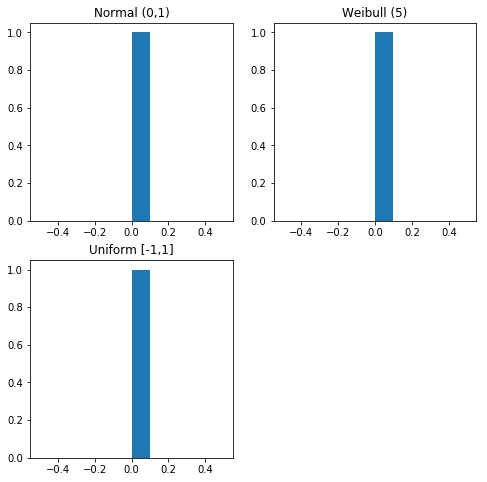

In [2]:
def PDF_dist():
    plt.figure(figsize=(8,8))
    f1 = np.random.normal(0,1,1000)
    f2 = np.random.normal(0,1,1000)
    dis,dis_test = wtest(f1,f2)
    plt.subplot(2,2,1)
    plt.hist(dis_test)
    plt.title('Normal (0,1)')
    
    f1 = np.random.weibull(5,1000)
    f2 = np.random.weibull(5,1000)
    dis,dis_test = wtest(f1,f2)
    plt.subplot(2,2,2)
    plt.hist(dis_test)
    plt.title('Weibull (5)')
    
    f1 = np.random.uniform(-1,1,1000)
    f2 = np.random.uniform(-1,1,1000)
    dis,dis_test = wtest(f1,f2)
    plt.subplot(2,2,3)
    plt.hist(dis_test)
    plt.title('Uniform [-1,1]')
    
PDF_dist()